# Random Forest Model for Crop Type and Land Classification


### Setup Notebook

In [ ]:
# Requirements, will skip if already installed
%pip install geopandas rasterio rasterstats shapely
%pip install folium earthengine-api
%pip install scikit-learn
%pip install treeinterpreter

In [ ]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from treeinterpreter import treeinterpreter as ti

### Connect Google Drive

In [ ]:
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/MyDrive/RS_crop_classification"

## Label data preparation

We will be using an already prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over.



In [83]:
# read in training data polygons that created as geojson from a shared directory
training_data = '/content/drive/MyDrive/RS_crop_classification/nirmal_new.geojson'
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()

,OBJECTID,FarmID,Crop,CropID,State,District,Mandal,SDate,HDate,CHealth,...,IrriMethod,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,Shape_Leng,Shape_Area,geometry
0,485,1328935.0,Bengal Gram,7.0,Telangana,Nirmal,Tanoor,11-12-2023,21-02-2024,Diseased,...,Drip,Drip,Groundwater,2.0,28.0,11.0,Rabi,0.003870,9.213000e-07,"MULTIPOLYGON (((77.87401 18.94069, 77.87369 18..."
1,486,1328936.0,Bengal Gram,7.0,Telangana,Nirmal,Tanoor,29-11-2023,03-04-2024,Healthy,...,Drip,Drip,Groundwater,3.0,23.0,11.0,Rabi,0.001431,1.064900e-07,"MULTIPOLYGON (((77.87547 18.93782, 77.87515 18..."
2,487,1328937.0,Bengal Gram,7.0,Telangana,Nirmal,Tanoor,10-10-2023,24-02-2024,Healthy,...,Sprinkler,Sprinkler,Groundwater,1.0,34.0,11.0,Rabi,0.001750,1.707500e-07,"MULTIPOLYGON (((77.87655 18.93749, 77.87625 18..."
3,488,1328938.0,Bengal Gram,7.0,Telangana,Nirmal,Tanoor,19-10-2023,25-04-2024,Healthy,...,Sprinkler,Sprinkler,Groundwater,1.0,26.0,12.0,Rabi,0.005212,9.246400e-07,"MULTIPOLYGON (((77.87870 18.93861, 77.87850 18..."
4,489,1328939.0,Bengal Gram,7.0,Telangana,Nirmal,Tanoor,10-06-2023,02-02-2024,Healthy,...,Sprinkler,Sprinkler,Groundwater,1.0,25.0,8.0,Rabi,0.002617,3.997300e-07,"MULTIPOLYGON (((77.88093 18.93826, 77.88080 18..."


In [84]:
training_vectors.columns

Index(['OBJECTID', 'FarmID', 'Crop', 'CropID', 'State', 'District', 'Mandal',
       'SDate', 'HDate', 'CHealth', 'CCov', 'CHeight', 'CStage', 'CNext',
       'CLast', 'CTransp', 'IrriMethod', 'IrriType', 'IrriSource', 'IrriCount',
       'WaterCov', 'ExpYield', 'Season', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [85]:
np.unique(training_vectors['Crop']),np.unique(training_vectors['CropID'])

(array(['Bengal Gram', 'Chillies', 'Groundnut', 'Maize', 'Paddy', 'fallow'],
       dtype=object),
 array([0., 1., 3., 5., 6., 7.]))

In [86]:
# Creating the dictionary
crop_dict = {}
for _, row in training_vectors.iterrows():
    crop_dict[row['CropID']] = row['Crop']

print(crop_dict)

{7.0: 'Bengal Gram', 1.0: 'Paddy', 6.0: 'Groundnut', 5.0: 'Chillies', 0.0: 'fallow', 3.0: 'Maize'}


In [87]:
training_vectors = training_vectors[['OBJECTID','CropID','geometry']]
training_vectors

,OBJECTID,CropID,geometry
0,485,7.0,"MULTIPOLYGON (((77.87401 18.94069, 77.87369 18..."
1,486,7.0,"MULTIPOLYGON (((77.87547 18.93782, 77.87515 18..."
2,487,7.0,"MULTIPOLYGON (((77.87655 18.93749, 77.87625 18..."
3,488,7.0,"MULTIPOLYGON (((77.87870 18.93861, 77.87850 18..."
4,489,7.0,"MULTIPOLYGON (((77.88093 18.93826, 77.88080 18..."
...,...,...,...
1777,0,3.0,"MULTIPOLYGON (((78.25740 19.20149, 78.25735 19..."
1778,0,3.0,"MULTIPOLYGON (((78.25794 19.19678, 78.25786 19..."
1779,0,3.0,"MULTIPOLYGON (((78.25757 19.19541, 78.25746 19..."
1780,0,3.0,"MULTIPOLYGON (((78.25624 19.19529, 78.25624 19..."


## Reading imagery from Google Earth Engine (GEE)

For this example we will be using Google Earth Engine to select and filter Satellite imagery that we will classify with the training data.

### Connect to GEE

In [ ]:
# Earth Engine Python API
import ee
ee.Authenticate()
ee.Initialize(project = 'ee-vertifysaptarshi')

### Search GEE Data

We will now search for Sentinel 2 imagery, a multispectral satellite with ~10m resolution and repeat coverage every 5 days.

Filters will include selecting bands, a date range, and only imagery within a defined Area of Interest (AOI).

In [ ]:
# From GEE
#training_vectors.total_bounds.tolist()
aoi = ee.Geometry.Rectangle(training_vectors.total_bounds.tolist())
band_sel = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(aoi)\
    .filterDate('2022-10-20', '2023-04-16')\
    .filterMetadata('CLOUD_COVERAGE_ASSESSMENT', 'less_than', 10)\
    .select(band_sel)

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

sentinel_mosaic.getInfo()

COPERNICUS/S2/20221023T051849_20221023T052729_T43QGA
COPERNICUS/S2/20221023T051849_20221023T052729_T43QGB
COPERNICUS/S2/20221023T051849_20221023T052729_T43QHA
COPERNICUS/S2/20221023T051849_20221023T052729_T43QHB
COPERNICUS/S2/20221023T051849_20221023T052729_T44QKF
COPERNICUS/S2/20221023T051849_20221023T052729_T44QKG
COPERNICUS/S2/20221025T050901_20221025T052128_T43QHA
COPERNICUS/S2/20221025T050901_20221025T052128_T43QHB
COPERNICUS/S2/20221025T050901_20221025T052128_T44QKF
COPERNICUS/S2/20221025T050901_20221025T052128_T44QKG
COPERNICUS/S2/20221028T051931_20221028T052450_T43QGA
COPERNICUS/S2/20221028T051931_20221028T052450_T43QGB
COPERNICUS/S2/20221028T051931_20221028T052450_T43QHA
COPERNICUS/S2/20221028T051931_20221028T052450_T43QHB
COPERNICUS/S2/20221028T051931_20221028T052450_T44QKF
COPERNICUS/S2/20221028T051931_20221028T052450_T44QKG
COPERNICUS/S2/20221030T050929_20221030T051554_T43QHA
COPERNICUS/S2/20221030T050929_20221030T051554_T43QHB
COPERNICUS/S2/20221030T050929_20221030T051554_

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B8',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B11',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B12',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'm

In [ ]:
# To make a map we first need some helper functions

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if gpd.geodataframe.GeoDataFrame == type(v):
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
      elif ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [ ]:
s2_vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}

Mapdisplay(center=[center.y, center.x],
           dicc={'S2':sentinel_mosaic.getMapId(s2_vis_params),
                 'TrainingData':training_vectors},
           zoom_start=12)


### Exporting Image

Since our analysis method in this example will happen outside of Google Earth Engine we will be exporting the search results to a Cloud Optimized Geotiff, a common GIS format for rasters. This will highlight that you can get imagery from any data source for this type of analysis.

In [ ]:
# We will save it to Google Drive for later reuse
raster_name = 'sentinel_mosaic-Nirmal'

In [ ]:
# Export the image, specifying scale and region.
# Warning, This specific export takes at least 1 hour, and 700+ MB
# There may be a bug here, not sure GEE export can write to a folder beyond depth 1 in a google drive
task = ee.batch.Export.image.toDrive(**{
    'image': sentinel_mosaic,
    'description': 'Trans_nirmal',
    'folder': my_root_dir,
    'fileNamePrefix': raster_name,
    'scale': 10,
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

# This task will run in the background even if you close this notebook.
# You can also check on the status of the task through the Javascript GEE interface
# https://code.earthengine.google.com
task.start()



In [ ]:
# If you want to keep track of the export you can run this code
# However if run this, you will need to wait for it to finish before running additional code

import time
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(15)

Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id: 3WWDSLJR5CP336J5TU5HJDR3).
Polling for task (id

In [ ]:
# Reference the raster on disk.
raster_path = op.join(my_root_dir, raster_name)
raster_file = ".".join([raster_path, "tif"])
# Alternate reference already prepared file on Google Drive, uncomment next line to use
#raster_file = '/content/drive/Shared drives/servir-sat-ml/data/Trans_nzoia_2019_05-02.tif'

print(raster_file)

/content/drive/MyDrive/RS_crop_classification/sentinel_mosaic-Nirmal.tif


## Model training

### Prepare Data

First we will need to do some preparation to organize the training data into the correct python types, and to extract sample pixels from the intersecting imagery.

In [88]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.CropID)
classes

array([0., 1., 3., 5., 6., 7.])

In [89]:
classes

array([0., 1., 3., 5., 6., 7.])

In [90]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, classes))
class_dict

{0.0: 0.0, 1.0: 1.0, 3.0: 3.0, 5.0: 5.0, 6.0: 6.0, 7.0: 7.0}

This section loops through the training classes and their polygons reading the imagery raster extracting values.

In [91]:
# raster information

##If you want to read the data directly from the shared folder, uncomment the following line.
raster_file = '/content/drive/MyDrive/ content drive MyDrive RS_crop_classification/sentinel_mosaic-Nirmal.tif'


# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.CropID, training_vectors.geometry):

        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)

        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)

        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [92]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((143117, 6), (143117,))

In addition to the raw pixel values we will calculated a couple of indices that help in some classifications.
* [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) - great for identiying photosynthesizing plants.
* [Normalized Difference Water Index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index) - great for identifying open water (when there isn't a lot of glare)

In [93]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(143117, 8)

Now were going to split 20% of the data to reserve for testing  the quality of the trained model.

In [94]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
np.unique(y_train)

array([0., 1., 3., 5., 6., 7.])

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [96]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0.0: 0.00014757969303423848,
 1.0: 0.0005015045135406219,
 3.0: 1.4107755032941609e-05,
 5.0: 0.008771929824561403,
 6.0: 0.00625,
 7.0: 2.893016258751374e-05}

In [133]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_counts_dict = dict(zip(labels, counts))
class_counts_dict

{0.0: 6776, 1.0: 1994, 3.0: 70883, 5.0: 114, 6.0: 160, 7.0: 34566}

### Train Model

In [118]:
# initialize a RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-1,
    verbose=1,
    random_state=0)

# initialize a DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=6,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            random_state=0,
                            min_impurity_decrease=0.0,
                            class_weight=class_weight_dict)
# initialize a Linear SVM Classifier
svm = SVC(tol=0.0002,
          C=0.8,
          class_weight=class_weight_dict,
          verbose=0,
          random_state=0,
          max_iter=500)

# initialize a GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='log_loss',
                                 learning_rate=0.15,
                                 n_estimators=120,
                                 criterion='friedman_mse',
                                 min_samples_split=2,
                                 max_depth=6,
                                 random_state=0,
                                 n_iter_no_change=3,
                                 verbose=1)

# Choose whichever model preferred/ to be tried
clf = dt


In [119]:
# fit the model to the data (training)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0.0: 0.00014757969303423848,
                                     1.0: 0.0005015045135406219,
                                     3.0: 1.4107755032941609e-05,
                                     5.0: 0.008771929824561403, 6.0: 0.00625,
                                     7.0: 2.893016258751374e-05},
                       max_depth=6, random_state=0)

In [120]:
# predict on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

In [121]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
report = classification_report(y_test, preds, labels=labels)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.39      0.79      0.52      1685
         1.0       0.16      0.69      0.26       522
         3.0       0.92      0.50      0.65     17578
         5.0       0.01      0.83      0.01        24
         6.0       0.03      0.78      0.06        40
         7.0       0.69      0.74      0.72      8775

    accuracy                           0.59     28624
   macro avg       0.37      0.72      0.37     28624
weighted avg       0.80      0.59      0.65     28624



In [122]:
crop_dict

{7.0: 'Bengal Gram',
 1.0: 'Paddy',
 6.0: 'Groundnut',
 5.0: 'Chillies',
 0.0: 'fallow',
 3.0: 'Maize'}

In [123]:
# (optional) save the trained model as python pickle file
# model_name = op.join(my_root_dir,'random_forest.sav')
# with open(model_name, 'wb') as modelfile:
#     pickle.dump(clf, modelfile)

### Assess the Model

A confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be. Low numbers are good. The diagonal from top left to bottom right, is a class compared to itself should be high. Values range from 0 to 1.

In [124]:
classes_crop = []
for i in classes:
  classes_crop.append(crop_dict[i])

classes_crop

['fallow', 'Paddy', 'Maize', 'Chillies', 'Groundnut', 'Bengal Gram']

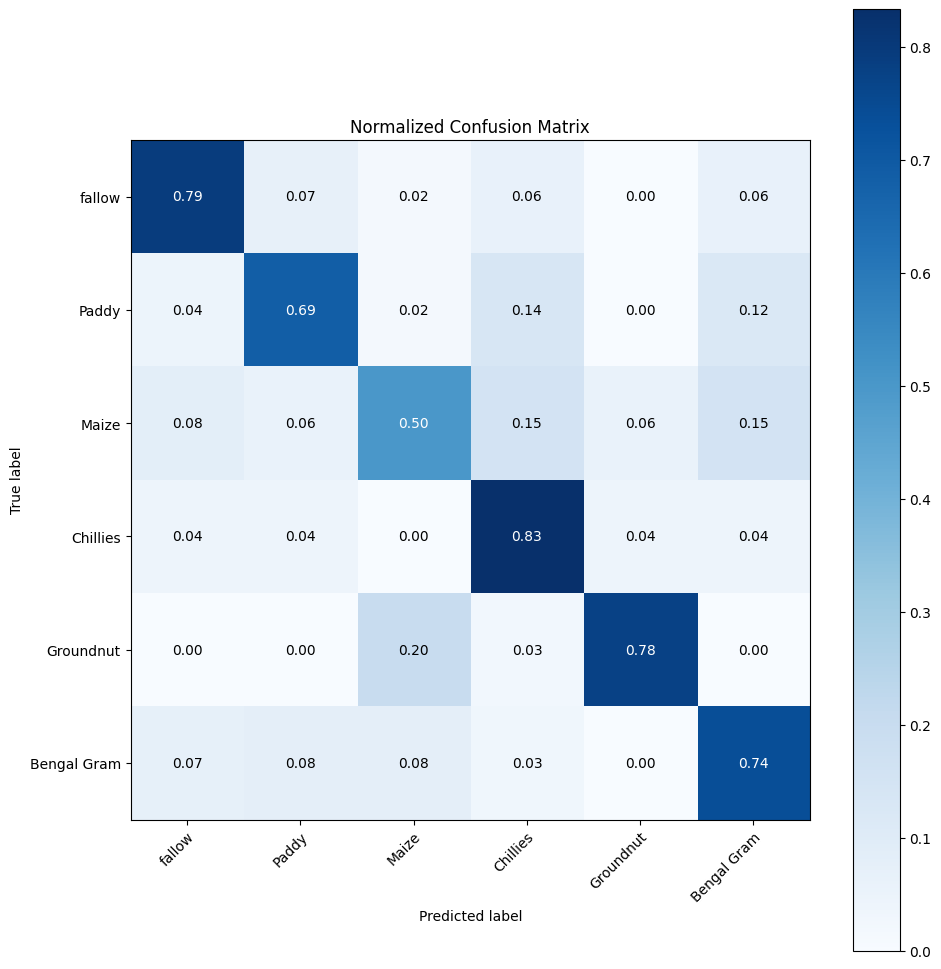

In [125]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes_crop, yticklabels=classes_crop,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

You can see the most often confused classes are Shadows with Clouds, Maize with Shadows, and Maize with Sugarcane.

In [126]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [127]:
# plot the contributions
band_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDWI']

gdf = gpd.GeoDataFrame(c, columns=classes_crop, index=band_names)
gdf.style.background_gradient(cmap='viridis')

,fallow,Paddy,Maize,Chillies,Groundnut,Bengal Gram
Blue,0.490911,-1.335281,6.870840,1.187023,-8.932721,1.719229
Green,-0.711953,0.818550,3.408223,-4.892864,-0.190222,1.568266
Red,0.055089,0.063324,0.416707,-1.538748,0.833606,0.170023
NIR,0.830339,-1.081651,1.327048,-0.017531,-1.270301,0.212097
SWIR1,-4.422085,-1.413357,2.157810,-0.762911,-0.479465,4.920007
SWIR2,0.747213,-0.251078,2.531581,-0.271824,-2.309285,-0.446606
NDVI,1.243493,0.320372,0.960644,-1.572573,-3.267980,2.316043
NDWI,-2.646346,-3.008683,2.618358,-1.464278,6.637219,-2.136271


## Using the Model

### Generate predictions over the full image

Now that we've trained and tested the model over the existing data we can use the trained RandomForestClassifier `clf` over a whole satellite image that covers a larger geospatial location. We can split the job into small tiles to optimize the compute power and potentially do the classification in parallel.

In [128]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(my_root_dir, "nirmal_classification_dt.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))

                # read the image into the proper format
                data = src.read(window=window)

                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = band_index(img_flat, 3, 2)
                img_ndwi = band_index(img_flat, 1, 3)

                img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = clf.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

### Make a Map


<ipython-input-64-070f78e02c5d>:32: RuntimeWarning: invalid value encountered in cast
  s2 = s2.astype(np.uint8)


<Axes: >

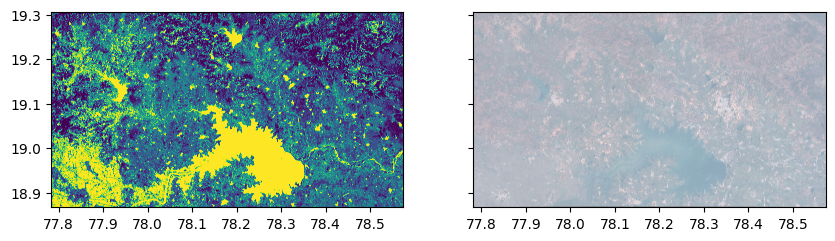

In [ ]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification

output_image = '/content/drive/MyDrive/RS_crop_classification/nirmal_classification_rf.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band],
            in_range=(0, 3000),
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)
